<a href="https://colab.research.google.com/github/saahil-jain/Covid_19_predictor/blob/master/NODE_for_dow_jones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from copy import deepcopy
import tensorflow
from sklearn.model_selection import train_test_split

print(os.getcwd())
if os.getcwd().split("/")[-1] == "Covid_19_predictor":
  print("Current working directory is already Covid_19_predictor")
elif os.path.isdir("Covid_19_predictor"):
  print("Covid_19_predictor already Exists")
else:
  ! git clone https://github.com/saahil-jain/Covid_19_predictor.git

/content/Covid_19_predictor
Current working directory is already Covid_19_predictor


In [34]:
%cd Covid_19_predictor/

[Errno 2] No such file or directory: 'Covid_19_predictor/'
/content/Covid_19_predictor


In [35]:
data=pd.read_csv('DowJones.csv')
data.set_index('Date')
data.head()

,Date,Value
0,1977-09-02,872.31
1,1977-09-09,857.04
2,1977-09-16,856.81
3,1977-09-23,839.14
4,1977-09-30,847.11


In [36]:
data.columns

Index(['Date', 'Value'], dtype='object')

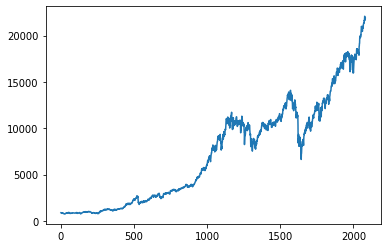

In [37]:
dow_values=list(data.Value)
plt.plot(dow_values)

In [38]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('x') for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('y') for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [39]:
#splitting the values of dow into X and y.
values = dow_values
timeseries = series_to_supervised(values)
X=timeseries.x
y=timeseries.y


In [40]:
#splitting X and y into test and train.
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, shuffle=False)


In [41]:
X_train=np.array(X_train).astype(np.float32)
X_test=np.array(X_test).astype(np.float32)
y_train=np.array(y_train).astype(np.float32)
y_test=np.array(y_test).astype(np.float32)

In [42]:
X_train,y_train

(array([ 872.31,  857.04,  856.81, ..., 9093.24, 9171.61, 9370.07],
       dtype=float32),
 array([ 857.04,  856.81,  839.14, ..., 9171.61, 9370.07, 9321.4 ],
       dtype=float32))

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, MultiStepLR

In [44]:
trainset = torch.utils.data.DataLoader((X_train,y_train), batch_size=10, shuffle=False)
len(trainset)

1

In [45]:
def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)
    
def zip_map(zipped, update_op):
    return [update_op(*elems) for elems in zipped]

def euler_update(h_list, dh_list, dt):
    return zip_map(zip(h_list, dh_list), lambda h, dh: h + dt * dh)

def euler_step(func, dt, state):
    return euler_update(state, func(state), dt)

def rk2_step(func, dt, state, **kwargs):
    k1 = func(state, **kwargs)
    k2 = func(euler_update(state, k1, dt), **kwargs)
    return zip_map(zip(state, k1, k2),
                   lambda h, dk1, dk2: h + dt * (dk1 + dk2) / 2)

def rk4_step(func, dt, state, **kwargs):
    k1 = func(state, **kwargs)
    k2 = func(euler_update(state, k1, dt / 2), **kwargs)
    k3 = func(euler_update(state, k2, dt / 2), **kwargs)
    k4 = func(euler_update(state, k3, dt), **kwargs)

    return zip_map(
        zip(state, k1, k2, k3, k4), lambda h, dk1, dk2, dk3, dk4: h + dt * ( dk1 + 2 * dk2 + 2 * dk3 + dk4) / 6,)
    
def forward_dynamics(state, nnet):
    t, y = state
    return [1.0, nnet(t, y)]

def backward_dynamics(state, nnet):
    with torch.set_grad_enabled(True):
        t, ht, at = state[0], state[1], state[2]
        ht = ht.detach()
        ht.requires_grad_(True)
        ht_new = nnet(t, ht)
        gradients = torch.autograd.grad(ht_new, [ht] + [w for w in nnet.parameters()], at, allow_unused=True, retain_graph=True)
    return [1.0, ht_new, *gradients]

class NeuralODEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, nnet, solver, t, *params):
        delta_t = t[1:] - t[:-1]

        ctx.nnet = nnet
        ctx.solver = solver
        ctx.delta_t = delta_t

        state = [0, input]
        for dt in delta_t:
            state = solver(func=forward_dynamics, dt=float(dt), state=state, nnet=nnet)
        output = state[1]
        
        ctx.save_for_backward(input, output)
        return output

    @staticmethod
    def backward(ctx, output_gradients):
        input, output = ctx.saved_tensors
        nnet = ctx.nnet
        solver = ctx.solver
        delta_t = ctx.delta_t
        params = nnet.parameters()

        grad_weights = []
        for p in params:
            grad_weights.append(torch.zeros_like(p))

        state = [1, output, output_gradients, *grad_weights]

        for i, dt in enumerate(delta_t):
            state = solver(func=backward_dynamics, dt=float(dt), state=state, nnet=nnet)

        grad_input = state[2]
        grad_weights = state[3:]
        return (grad_input, None, None, None, *grad_weights)

class NeuralODE(nn.Module):
    def __init__(self, model, solver=rk4_step, t=np.linspace(0,99,99)):
      super().__init__()
      self.t = t
      self.model = model
      self.solver = solver
      self.params = [w for w in model.parameters()]

    def changetime(self, x):
      self.t = np.array([n+1 for n in range(x)])

    def forward(self, input):
      return NeuralODEFunction.apply(input, self.model, self.solver, self.t, *self.params)

# class ODEfunc(nn.Module):
#     def __init__(self, dim):
#         super(ODEfunc, self).__init__()
#         self.norm1 = norm(dim)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
#         self.norm2 = norm(dim)
#         self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
#         self.norm3 = norm(dim)
#         self.nfe = 0

#     def forward(self, x):
#         self.nfe += 1
#         out = self.norm1(x)
#         out = self.relu(out)
#         out = self.conv1(t, out)
#         out = self.norm2(out)
#         out = self.relu(out)
#         out = self.conv2(t, out)
#         out = self.norm3(out)
#         return out

class arguments:
  def __init__(self):
    self.batch_size=64
    self.test_batch_size=1000
    self.epochs=15
    self.lr=0.01
    self.gamma=0.7
    self.seed=1
    self.log_interval=5
    
args=arguments()
device = torch.device("cuda")

In [46]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.fc1 = nn.Linear(1, 64)
      self.fc2 = nn.Linear(64, 64)
      self.fc3 = nn.Linear(64, 256)
      # self.fc4 = nn.Linear(128, 256)
      # self.fc5 = nn.Linear(256, 512)
      # self.fc6 = nn.Linear(256, 256)
      # self.fc7 = nn.Linear(512, 256)
      # self.fc8 = nn.Linear(256, 128)
      self.fc9 = nn.Linear(256, 64)
      self.fc10 = nn.Linear(64, 64)
      self.fc11 = nn.Linear(64, 1)

    def forward(self, t, x):
      x = torch.tanh(self.fc1(x))
      x = torch.tanh(self.fc2(x))
      x = torch.tanh(self.fc3(x))
      # x = torch.tanh(self.fc4(x))
      # x = torch.tanh(self.fc5(x))
      # x = torch.tanh(self.fc6(x))
      # x = torch.tanh(self.fc7(x))
      # x = torch.tanh(self.fc8(x))
      x = torch.tanh(self.fc9(x))
      x = torch.tanh(self.fc10(x))
      x = torch.tanh(self.fc11(x))
      return x

In [75]:

def train(args, model, device, train_loader, optimizer, epoch, loss_values):
  #optimizer = optim.Rprop(model.parameters(), lr=0.01, etas=(0.5, 1.2), step_sizes=(1e-06, 50))
  for (x,y) in enumerate(train_loader):
    y=y.view(1664,2,1)
    data = y[0]
    target = y[1]
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_function(output,target)
    loss.backward()
    optimizer.step()
    loss_values.append(loss)
    print("{0:45s}".format('Train Loss'), loss.item())
    


Train Epoch: 0
Train Loss                                    977.0585327148438

Train Epoch: 1
Train Loss                                    39.24661636352539

Train Epoch: 2
Train Loss                                    64.0660629272461

Train Epoch: 3
Train Loss                                    146.7105712890625

Train Epoch: 4
Train Loss                                    148.156005859375

Train Epoch: 5
Train Loss                                    122.83706665039062

Train Epoch: 6
Train Loss                                    97.08594512939453

Train Epoch: 7
Train Loss                                    77.1859359741211

Train Epoch: 8
Train Loss                                    63.21692657470703

Train Epoch: 9
Train Loss                                    53.56572723388672

Train Epoch: 10
Train Loss                                    47.04655075073242

Train Epoch: 11
Train Loss                                    42.55784225463867

Train Epoch: 12
Train Loss             

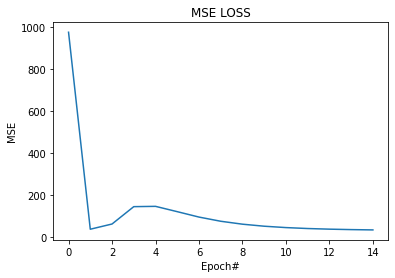

In [80]:
%%time
loss_values=[]

model_cases = Net().to(device)
model_cases = NeuralODE(model_cases)
loss_function=nn.MSELoss()

optimizer = optim.Adam(model_cases.parameters(), lr = 0.001)

NODE_loss_cases = {}
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

epochs = 15

for epoch in range(epochs):
    print('\nTrain Epoch: {}'.format(epoch))
    # model_cases.changetime(trainset_cases_pre[country]["X"].shape[0])
    train(args, model_cases, device, trainset, optimizer, epoch, loss_values)
    # NODE_loss_cases[country] = test(args, model_cases, device, testset_cases[country], country, op_cases_test)
    scheduler.step()

plt.title('MSE LOSS')
plt.plot(loss_values)
plt.xlabel('Epoch#')
plt.ylabel('MSE')
